In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

import miura_method as mm
import response_factor as rf

In [2]:
# 壁体内の分割数
n_layers = 2

# 留数定理による根の数の最大値
n_alpha_max = 200

# 時間間隔
delta_t = 900.0

# 壁体番号
wall_index = 6

# 計算する壁体構成の定義

In [3]:
d = {
    'walls': [
        {
            'name': '1F床（木造）',
            'R': [0.15, 0.022 / 0.16, 0.15 / 0.05, 0.04],
            'C': [0.0, 720 * 0.022 * 1000, 13 * 0.15 * 1000, 0.0]
        },
        {
            'name': '外壁（木造）',
            'R': [0.11, 0.012 / 0.22, 0.1 / 0.05, 1 / 11.11, 0.009 / 0.16, 0.03 / 1.5, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 13 * 0.1 * 1000, 0.0, 720 * 0.009 * 1000, 1600 * 0.03 * 1000, 0.0]
        },
        {
            'name': '2階天井（木造）',
            'R': [0.09, 0.012 / 0.22, 0.2 / 0.05, 1 / 11.11, 0.012 / 0.16, 0.001 / 55, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 8 * 0.2 * 1000, 0.0, 720 * 0.012 * 1000, 3600 * 0.001 * 1000, 0.0]
        },
        {
            'name': '間仕切',
            'R': [0.11, 0.012 / 0.22, 1 / 11.11, 0.012 / 0.22, 0.11],
            'C': [0.0, 830 * 0.012 * 1000, 0.0, 830 * 0.012 * 1000, 0.0]
        },
        {
            'name': '屋根（RC）',
            'R': [0.09, 0.012 / 0.22, 1 / 11.11, 0.05 / 0.028, 0.135 / 1.6, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 0.0, 40 * 0.05 * 1000, 0.135 * 2000 * 1000, 0.0]
        },
        {
            'name': '外壁（RC）',
            'R': [0.11, 0.012 / 0.22, 1 / 11.11, 0.05 / 0.028, 0.15 / 1.6, 0.04],
            'C': [0.0, 830 * 0.012 * 1000, 0.0, 0.05 * 40 * 1000, 0.15 * 2000 * 1000,  0.0]
        },
        {
            'name': '床（RC）',
            'R': [0.15, 0.022 / 0.16, 1 / 11.11, 0.13 / 1.6, 0.05 / 0.028, 0.04],
            'C': [0.0, 720 * 0.022 * 1000, 0.0, 2000 * 0.13 * 1000, 40 * 0.05 * 1000, 0.0]
        },
        {
            'name': '天井（木造）UA=0.2',
            'R': [0.09, 0.01 / 0.22, 0.644 / 0.05, 0.04],
            'C': [0.0, 830 * 0.01 * 1000, 8 * 0.01 * 1000, 0.0]
        }
    ]
}


# 壁体構成の定義
# R = np.array([1.0 / 9.3, 0.025 / 0.19, 0.06 / 1.4, 0.06 / 1.4, 0.05 / 0.042, 0.04])  # 抵抗値
# C = np.array([0.0, 716 * 1000 * 0.025, 1934 * 1000 * 0.06, 1934 * 1000 * 0.06, 84 * 1000 * 0.05, 0.0])  # 容量値
R = np.array(d['walls'][wall_index]['R'])
C = np.array(d['walls'][wall_index]['C'])

In [4]:
# RMSEの計算関数
def RMSE(rf: np.ndarray, fdm: np.ndarray):
    return np.sqrt(mean_squared_error(rf, fdm))

# 後退差分計算のための壁体分割

In [5]:
# 差分計算する層間の熱抵抗と格子点熱容量の計算
virtual_R, virtual_C = mm.miura_method(R=R, C=C, n_layers=n_layers)
print(virtual_R)
print(virtual_C)

[0.15       0.27081367 1.82365962 0.04      ]
[ 77207.47252747 138920.          61712.52747253]


# 後退差分計算のための係数行列の作成

In [6]:
print(virtual_R)
print(virtual_R[1:])
print(virtual_R[:len(virtual_C)])

u_L = delta_t / (virtual_C * virtual_R[:len(virtual_C)])
u_R = delta_t / (virtual_C * virtual_R[1:])

print(u_L)
print(u_R)

[0.15       0.27081367 1.82365962 0.04      ]
[0.27081367 1.82365962 0.04      ]
[0.15       0.27081367 1.82365962]
[0.07771269 0.02392253 0.00799697]
[0.043044   0.0035525  0.36459372]


In [7]:
# 行列[U]の作成
matrix_U = np.zeros((n_layers + 1, n_layers + 1))
for i in range(n_layers + 1):
    matrix_U[i, i] = 1.0 + u_L[i] + u_R[i]
    if i > 0:
        matrix_U[i, i - 1] = - u_L[i]
        matrix_U[i - 1, i] = - u_R[i - 1]

print(matrix_U)

[[ 1.12075668 -0.043044    0.        ]
 [-0.02392253  1.02747503 -0.0035525 ]
 [ 0.         -0.00799697  1.37259069]]


In [8]:
# 逆行列の計算
inv_U = np.linalg.inv(matrix_U)
print(inv_U)

[[8.93052917e-01 3.74134066e-02 9.68322804e-05]
 [2.07932232e-02 9.74150374e-01 2.52126739e-03]
 [1.21145186e-04 5.67558129e-03 7.28564000e-01]]


In [9]:
# 差分法による単位応答の計算
n_max = int(100 / (delta_t / 3600))

# 後退差分法による単位応答の計算

In [10]:
# 初期温度
theta_0 = np.zeros(n_layers + 1)
# 境界温度（吸熱応答用）
theta_boundary_a = np.zeros(n_layers + 1)
theta_boundary_a[0] = u_L[0] * 1.0
# 熱流
q_a = np.zeros(n_max)

for i in range(n_max):
    theta_0 = np.dot(inv_U, (theta_0 + theta_boundary_a))
    q_a[i] = (1.0 - theta_0[0]) / R[0]

print(q_a)

[6.20398973 5.7903917  5.42027419 5.08868475 4.79124223 4.52407069
 4.2837411  4.06721962 3.87182195 3.69517297 3.535171   3.38995618
 3.25788258 3.13749343 3.02749935 2.92675893 2.83426169 2.74911297
 2.67052053 2.59778273 2.53027809 2.46745601 2.40882865 2.35396361
 2.3024776  2.25403075 2.20832162 2.16508275 2.12407678 2.08509294
 2.04794402 2.01246368 1.978504   1.9459334  1.91463475 1.88450371
 1.8554473  1.82738252 1.80023531 1.77393945 1.7484357  1.72367098
 1.69959772 1.67617316 1.65335889 1.63112029 1.60942612 1.58824816
 1.56756085 1.54734101 1.52756755 1.50822128 1.48928464 1.47074157
 1.45257734 1.43477839 1.41733219 1.40022719 1.38345263 1.36699854
 1.35085559 1.33501507 1.3194688  1.30420911 1.28922874 1.27452083
 1.26007889 1.24589673 1.23196849 1.21828853 1.2048515  1.19165223
 1.17868577 1.16594737 1.15343243 1.14113652 1.12905535 1.11718476
 1.10552074 1.09405936 1.08279684 1.07172947 1.06085365 1.05016589
 1.03966274 1.02934089 1.01919705 1.00922805 0.99943076 0.9898

In [11]:
# 初期温度
theta_0 = np.zeros(n_layers + 1)
# 境界温度（貫流応答用）
theta_boundary_t = np.zeros(n_layers + 1)
theta_boundary_t[len(theta_boundary_t) - 1] = u_R[len(u_R) - 1] * 1.0
# 熱流
q_t = np.zeros(n_max)

for i in range(n_max):
    theta_0 = np.dot(inv_U, (theta_0 + theta_boundary_t))
    q_t[i] = (theta_0[0] - 0.0) / R[0]

print(q_t)

[2.35362942e-04 8.46310370e-04 1.90743364e-03 3.44876630e-03
 5.47075803e-03 7.95484955e-03 1.08708814e-02 1.41822301e-02
 1.78493196e-02 2.18319745e-02 2.60909547e-02 3.05889133e-02
 3.52909535e-02 4.01649093e-02 4.51814402e-02 5.03140020e-02
 5.55387392e-02 6.08343313e-02 6.61818119e-02 7.15643786e-02
 7.69672009e-02 8.23772344e-02 8.77830433e-02 9.31746354e-02
 9.85433094e-02 1.03881515e-01 1.09182727e-01 1.14441329e-01
 1.19652512e-01 1.24812179e-01 1.29916866e-01 1.34963664e-01
 1.39950159e-01 1.44874365e-01 1.49734682e-01 1.54529840e-01
 1.59258866e-01 1.63921043e-01 1.68515881e-01 1.73043086e-01
 1.77502536e-01 1.81894260e-01 1.86218416e-01 1.90475276e-01
 1.94665208e-01 1.98788667e-01 2.02846178e-01 2.06838329e-01
 2.10765759e-01 2.14629154e-01 2.18429235e-01 2.22166756e-01
 2.25842494e-01 2.29457249e-01 2.33011836e-01 2.36507082e-01
 2.39943825e-01 2.43322907e-01 2.46645178e-01 2.49911485e-01
 2.53122677e-01 2.56279602e-01 2.59383103e-01 2.62434020e-01
 2.65433186e-01 2.683814

# 留数定理を用いた単位応答の計算

In [12]:
# 留数定理での単位応答の計算
# 根の計算
a0, aa, at, alpha = rf.calc_alpha_matsuo_method(rs=R, cs=C, i_max=n_alpha_max)

# 単位応答の計算
phi_a, phi_t = rf.calc_step_respose_factor(aa=aa, at=at, alpha=alpha, a0=a0, n_max=n_max, delta_t=delta_t)

# 応答係数の初項、指数項別応答係数の計算
rft_a0, rft_t0, rft_a1, rft_t1, Row = rf.calc_triangle_response_factor(aa=aa, at=at, alpha=alpha, a0=a0, delta_t=delta_t)

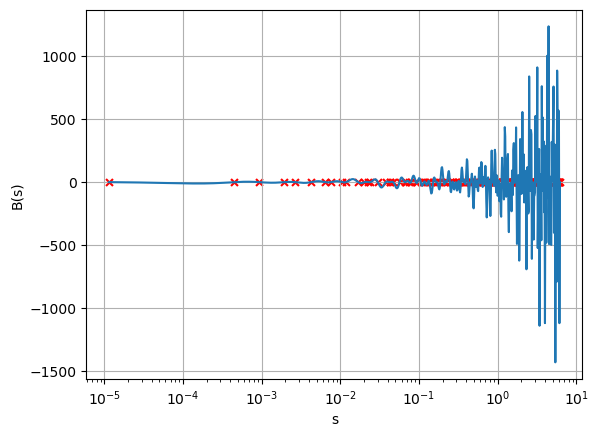

In [13]:
laps, Bs = rf.calc_Bs(rs=R, cs=C, alpha=alpha)
zero = np.zeros_like(alpha)
plt.scatter(laps, Bs, marker="None")
plt.scatter(alpha, zero, marker='x', c='r', s=25)
plt.plot(laps, Bs)
plt.xlabel('s')
plt.ylabel('B(s)')
plt.xscale('log')
plt.grid()
plt.show()

# グラフ描画

In [14]:
# 横軸
tt = np.arange(0, delta_t / 3600.0 * (n_max), delta_t / 3600.0)

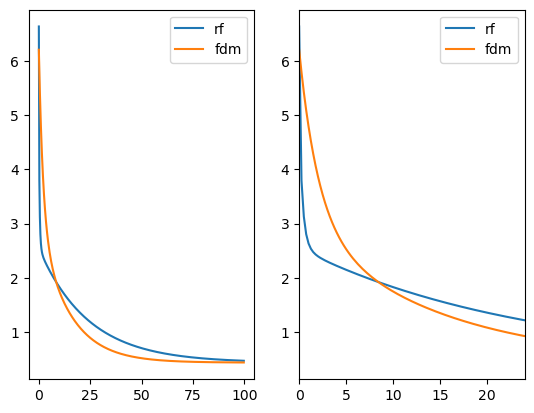

In [15]:
fig, ax = plt.subplots(1, 2, squeeze=False)

ax[0,0].plot(tt, phi_a, label='rf')
ax[0,0].plot(tt, q_a, label='fdm')
ax[0,0].legend()

ax[0,1] = plt.plot(tt, phi_a, label='rf')
ax[0,1] = plt.plot(tt, q_a, label='fdm')
ax[0,1] = plt.legend()
ax[0,1] = plt.xlim(0.0, 24.0)
plt.show()

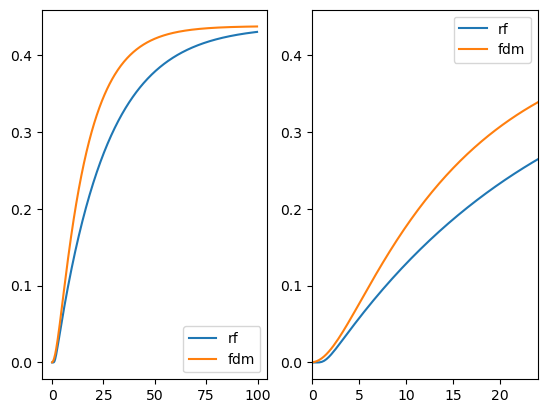

In [16]:
fig, ax = plt.subplots(1, 2, squeeze=False)

ax[0,0].plot(tt, phi_t, label='rf')
ax[0,0].plot(tt, q_t, label='fdm')
ax[0,0].legend()

ax[0,1] = plt.plot(tt, phi_t, label='rf')
ax[0,1] = plt.plot(tt, q_t, label='fdm')
ax[0,1] = plt.legend()
ax[0,1] = plt.xlim(0.0, 24.0)
plt.show()

In [17]:
# RMSEの計算
rmse_a = RMSE(rf=phi_a, fdm=q_a)
# 24時間分のRMSEを計算
n_24 = int(24 * 3600 / delta_t)
rmse_a_24 = RMSE(rf=phi_a[n_24:], fdm=q_a[n_24:])

rmse_t = RMSE(rf=phi_t, fdm=q_t)
rmse_t_24 = RMSE(rf=phi_t[n_24:], fdm=q_t[n_24:])

print(rmse_a, rmse_a_24)
print(rmse_t, rmse_t_24)

0.360353276011911 0.16984786631617177
0.044067119353191984 0.04032163119930711


In [18]:
# MAEの計算
mae_a = mean_absolute_error(phi_a, q_a)
# 24時間分のRMSEを計算
mae_a_24 = mean_absolute_error(phi_a[n_24:], q_a[n_24:])

mae_t = mean_absolute_error(phi_t, q_t)
mae_t_24 = mean_absolute_error(phi_t[n_24:], q_t[n_24:])

print(mae_a, mae_a_24)
print(mae_t, mae_t_24)

0.21148996161935535 0.14580852695582255
0.03747275534458634 0.034159701723022955


# 三角関数の境界条件を与えた時の室内表面熱流の計算

In [19]:
# 境界条件
time_angle = np.arange(start=0.0, stop=365+delta_t/3600/24, step=delta_t/3600/24, dtype=float)
theta_eo_array = np.sin(time_angle * (2 * math.pi))
# theta_eo_array = np.full_like(time_angle, 1.0)
theta_ei_array = np.cos(time_angle * (2 * math.pi))
# theta_ei_array = np.zeros_like(theta_eo_array)
print(theta_eo_array)

[ 0.00000000e+00  6.54031292e-02  1.30526192e-01 ... -6.54031292e-02
  8.82364676e-14  6.54031292e-02]


In [20]:
# 後退差分法での計算
# 初期温度
theta_0 = np.zeros(n_layers + 1)
# 境界温度（貫流応答用）
theta_boundary = np.zeros((n_layers + 1, len(theta_eo_array)))
theta_boundary[0,:] = u_L[0] * theta_ei_array
theta_boundary[len(theta_boundary) - 1,:] = u_R[len(u_R) - 1] * theta_eo_array
# 熱流
q_fdm = np.zeros_like(theta_eo_array)
# 表面温度
theta_surf = np.zeros_like(theta_eo_array)

for i, time in enumerate(time_angle):
    theta_0 = np.dot(inv_U, (theta_0 + theta_boundary[:, i]))
    q_fdm[i] = (theta_0[0] - theta_ei_array[i]) / R[0]
    theta_surf[i] = theta_0[0]

print(q_fdm)
print(theta_surf)
print(np.sum(R))

[-6.20398973 -5.77709309 -5.36801306 ... -3.82762343 -3.70366854
 -3.56385397]
[0.06940154 0.13129496 0.1862429  ... 0.42371541 0.44444972 0.46328083]
2.284473286614376


In [21]:
# 応答係数法での計算
q_dsh_srf_t = np.zeros_like(alpha)
q_dsh_srf_a = np.zeros_like(alpha)

# 熱流
q_rf = np.zeros_like(theta_eo_array)
theta_rf_surf = np.zeros_like(theta_eo_array)

for i, time in enumerate(time_angle):
    q_rf[i] = rft_t0 * theta_eo_array[i] + np.sum(q_dsh_srf_t) \
                - (rft_a0 * theta_ei_array[i] + np.sum(q_dsh_srf_a))
    q_dsh_srf_a = theta_ei_array[i] * rft_a1 + Row * q_dsh_srf_a
    q_dsh_srf_t = theta_eo_array[i] * rft_t1 + Row * q_dsh_srf_t
    theta_rf_surf[i] = q_rf[i] * R[0] + theta_ei_array[i]

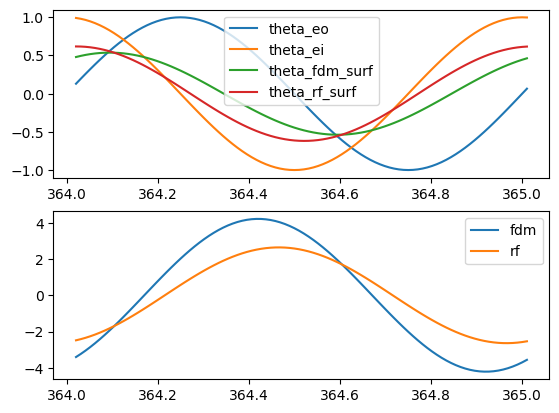

In [22]:
# 1日のステップ数
n_step = int(24 * 3600 / delta_t)

fig, ax = plt.subplots(2, 1, squeeze=False)

ax[0,0].plot(time_angle[-n_step:], theta_eo_array[-n_step:], label='theta_eo')
ax[0,0].plot(time_angle[-n_step:], theta_ei_array[-n_step:], label='theta_ei')
ax[0,0].plot(time_angle[-n_step:], theta_surf[-n_step:], label='theta_fdm_surf')
ax[0,0].plot(time_angle[-n_step:], theta_rf_surf[-n_step:], label='theta_rf_surf')
ax[0,0].legend()

ax[1,0] = plt.plot(time_angle[-n_step:], q_fdm[-n_step:], label='fdm')
ax[1,0] = plt.plot(time_angle[-n_step:], q_rf[-n_step:], label='rf')
ax[1,0] = plt.legend()

115.99407001629052 -115.99407001629027
72.70164486507933 -72.70164486507929


<BarContainer object of 2 artists>

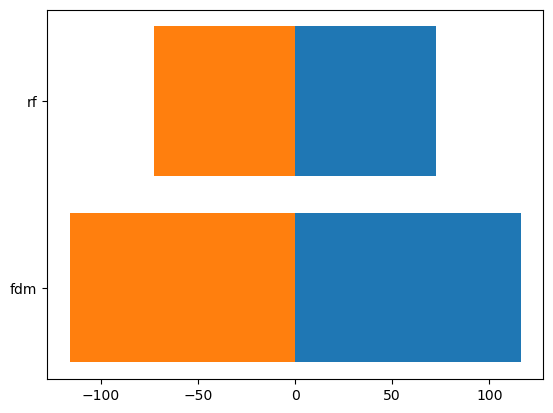

In [23]:
q_fdm_lastday = q_fdm[-n_step:]
q_rf_lastday = q_rf[-n_step:]

# 正値だけの積算
sum_q_fdm_lastday_pls = np.sum(q_fdm_lastday[q_fdm_lastday > 0]) * delta_t / 1000
sum_q_rf_lastday_pls = np.sum(q_rf_lastday[q_rf_lastday > 0]) * delta_t / 1000

# 負値だけの積算
sum_q_fdm_lastday_mns = np.sum(q_fdm_lastday[q_fdm_lastday < 0]) * delta_t / 1000
sum_q_rf_lastday_mns = np.sum(q_rf_lastday[q_rf_lastday < 0]) * delta_t / 1000

print(sum_q_fdm_lastday_pls, sum_q_fdm_lastday_mns)
print(sum_q_rf_lastday_pls, sum_q_rf_lastday_mns)

plt.barh(['fdm', 'rf'], [sum_q_fdm_lastday_pls, sum_q_rf_lastday_pls])
plt.barh(['fdm', 'rf'], [sum_q_fdm_lastday_mns, sum_q_rf_lastday_mns])

In [24]:
# RMSEの計算
rmse_trif = RMSE(rf=q_rf_lastday, fdm=q_fdm_lastday)
print(rmse_trif)

1.297083170815253


In [25]:
# MAEの計算
mae_trif = mean_absolute_error(q_rf_lastday, q_fdm_lastday)
print(mae_trif)

1.167487216707758
